In [8]:
import cv2
import os
import tensorflow as tf
import numpy as np

path=r'E:/tupian/'
#由于我们的数据集图片大小不一致，所以需要resize成统一大小 这里resize成100x100x3
w=100
h=100
c=3
#data 对应图片, label 是标签，roses 0,daisy 1,sunflowers 2,tulips 3,dandelion 4.
def read_img(path):
    imgs=[]
    labels=[]
    cate=[path+x for x in os.listdir(path) if os.path.isdir(path+x)]
    for idx,i in enumerate(cate):
        for j in os.listdir(i):
            im = cv2.imread(i+'/'+j)
            img = cv2.resize(im, (w, h))/255.
            imgs.append(img)
            labels.append(idx)
    return np.asarray(imgs,np.float32),np.asarray(labels,np.int32)
data,label=read_img(path)
#打乱顺序
num_example=data.shape[0] # data.shape是(3029, 100, 100, 3)
arr=np.arange(num_example)# 创建等差数组 0，1，...,3028
np.random.shuffle(arr)# 打乱顺序
data=data[arr]
label=label[arr]
print(label)

def to_one_hot(labels):
    l = len(labels)
    res = np.zeros((l, 3), dtype=np.float32)
    for i in range(l):
        res[i][labels[i]] = 1.
    return res
label_oh = to_one_hot(label)
#划分80%训练集
ratio=0.8
s=np.int(num_example*ratio)
x_train=data[:s]
y_train=label_oh[:s]
x_test=data[s:]
y_test=label_oh[s:]


[0 1 2 ... 1 0 0]


In [9]:
np.shape(x_test)

(1540, 100, 100, 3)

In [10]:
np.shape(x_train)

(6158, 100, 100, 3)

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam

batch_size = 32
num_classes = 3
epochs = 10
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',  # 32，(3,3)是卷积核数量和大小
                 input_shape=x_train.shape[1:]))  # 第一层需要指出图像的大小
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = tf.keras.optimizers.Adam()

# Let's train the model using RMSprop
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=opt,
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 100, 100, 32)      896       
_________________________________________________________________
activation_6 (Activation)    (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 98, 98, 32)        9248      
_________________________________________________________________
activation_7 (Activation)    (None, 98, 98, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 49, 49, 64)       

In [13]:
batch_size = 32
num_classes = 3
epochs = 30
history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)

Train on 6158 samples, validate on 1540 samples
Epoch 1/30
6158/6158 [==============================] - 372s 60ms/sample - loss: 0.9231 - accuracy: 0.5110 - val_loss: 0.7773 - val_accuracy: 0.6532
Epoch 2/30
6158/6158 [==============================] - 399s 65ms/sample - loss: 0.7563 - accuracy: 0.6517 - val_loss: 0.6683 - val_accuracy: 0.6942
Epoch 3/30
6158/6158 [==============================] - 491s 80ms/sample - loss: 0.6139 - accuracy: 0.7361 - val_loss: 0.5578 - val_accuracy: 0.7760
Epoch 4/30
6158/6158 [==============================] - 416s 68ms/sample - loss: 0.4757 - accuracy: 0.8123 - val_loss: 0.4275 - val_accuracy: 0.8325
Epoch 5/30
6158/6158 [==============================] - 353s 57ms/sample - loss: 0.3764 - accuracy: 0.8610 - val_loss: 0.3828 - val_accuracy: 0.8474
Epoch 6/30
6158/6158 [==============================] - 352s 57ms/sample - loss: 0.3199 - accuracy: 0.8750 - val_loss: 0.2691 - val_accuracy: 0.9013
Epoch 7/30
6158/6158 [==============================] - 35

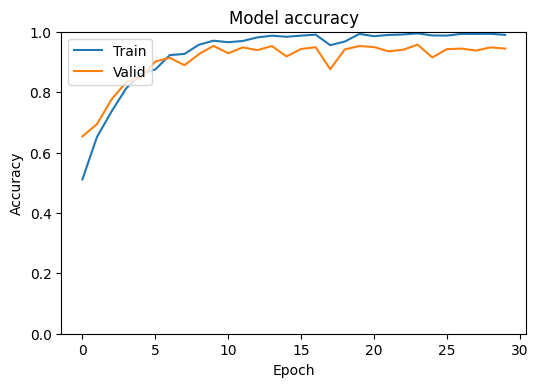

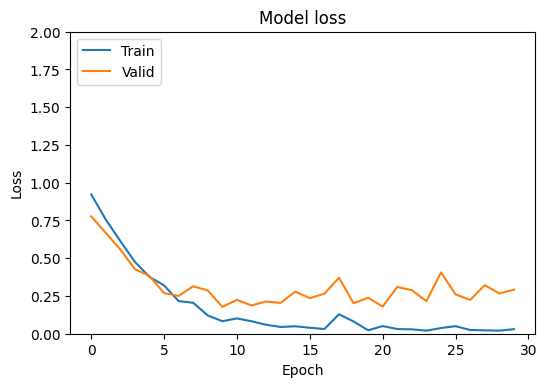

In [40]:
import matplotlib.pyplot as plt
# 绘制训练 & 验证的准确率值
plt.figure(dpi=100)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim([0,1])
plt.legend(['Train', 'Valid'], loc='upper left')
plt.savefig('tradition_cnn_valid_acc.png')
plt.show()

# 绘制训练 & 验证的损失值
plt.figure(dpi=100)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.ylim([0,2])
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.savefig('tradition_cnn_valid_loss.png')
plt.show()

In [45]:
tf.saved_model.save(model,'densenet')  
#way2 保存model成 .h5格式 里面包含了模型结构和训练好的模型参数
model.save('densenet.h5')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: densenet\assets


In [2]:
#读表
#用于训练GBDT
import pandas as pd
import numpy as np
data2 = pd.read_excel('E:/2021MCM_ProblemC_Files/2021_MCM_Problem_C_Data/2021MCM_ProblemC_ Images_by_GlobalID.xlsx')
shu= pd.read_excel('E:/2021MCM_ProblemC_Files/2021_MCM_Problem_C_Data/1.xlsx')

yu=pd.merge(shu.loc[:,['GlobalID','wen','Lab Status']],data2.loc[:,['GlobalID','FileName']], how='left', on=['GlobalID'])
yu.FileName.fillna(str('bai.jpg'),inplace=True)

C:\Users\super qing\Anaconda3\lib\site-packages\pandas\core\indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [3]:
x=yu['FileName'].tolist()
len(x)

5536

In [16]:
# import os
# c=1
# for i in x:
#         path='E:/2021MCM_ProblemC_Files/2021MCM_ProblemC_Files/'+i
#         c=c+1
#         if  not os.path.exists(path):
#             print(path+'  '+str(c))
    

E:/2021MCM_ProblemC_Files/2021MCM_ProblemC_Files/ATT46_trim.75A56855-B3BF-4B3D-8E9F-3E34CE90D8FB.jpg  101
E:/2021MCM_ProblemC_Files/2021MCM_ProblemC_Files/ATT56_trim.3077122A-A53F-4956-A536-8DFBEBD3CC56.jpg  119
E:/2021MCM_ProblemC_Files/2021MCM_ProblemC_Files/ATT174_trim.B1F11C96-C2F8-4401-AC39-E41EC93ED758.jpg  737
E:/2021MCM_ProblemC_Files/2021MCM_ProblemC_Files/ATT255_ASIAN GIANT HORNET_ 2020 0524 2.26 pm (Combined Clip).jpg  867
E:/2021MCM_ProblemC_Files/2021MCM_ProblemC_Files/ATT260_trim.9CD5B8C5-CBCC-4EAE-AB2D-3E2D2C169F7B.jpg  874
E:/2021MCM_ProblemC_Files/2021MCM_ProblemC_Files/ATT302_trim.146B941C-A15C-43F2-BDC0-25D2288D933C.jpg  935
E:/2021MCM_ProblemC_Files/2021MCM_ProblemC_Files/ATT303_email Potential Asian Murder Hornet Sighting.jpg  939
E:/2021MCM_ProblemC_Files/2021MCM_ProblemC_Files/ATT349_inbound45722360591262683.jpg  1013
E:/2021MCM_ProblemC_Files/2021MCM_ProblemC_Files/ATT439_trim.52424BC0-74B6-4E5F-8ED0-A41999D6D21C.jpg  1147
E:/2021MCM_ProblemC_Files/2021MCM_Probl

In [4]:
#
import cv2
import os
w=100
h=100
c=3
def read_img(x):
    imgs=[]
    labels=[]
    
    for i in x:
        path='E:/2021MCM_ProblemC_Files/2021MCM_ProblemC_Files/'+i
        
        if  os.path.exists(path):
            im = cv2.imread(path)
            img = cv2.resize(im, (w, h))/255.
            imgs.append(img)
        else:
            im = cv2.imread('E:/2021MCM_ProblemC_Files/2021MCM_ProblemC_Files/bai.jpg')
            img = cv2.resize(im, (w, h))/255.
            imgs.append(img)
    return np.asarray(imgs,np.float32)
data=read_img(x)

In [6]:
data.shape

(5536, 100, 100, 3)

In [8]:
import tensorflow as tf
network = tf.keras.models.load_model('densenet.h5')


In [9]:
network.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 100, 100, 32)      896       
_________________________________________________________________
activation_6 (Activation)    (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 98, 98, 32)        9248      
_________________________________________________________________
activation_7 (Activation)    (None, 98, 98, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 49, 49, 64)       

In [10]:
y_predict=network.predict(data)

In [12]:
len(y_predict)

5536

In [13]:
y_predict=network.predict(data)
df=pd.DataFrame(y_predict)
df.to_excel('E:/2021MCM_ProblemC_Files/2021_MCM_Problem_C_Data/resultcv2.xlsx',index=False)

In [14]:
shu= pd.read_excel('E:/2021MCM_ProblemC_Files/2021_MCM_Problem_C_Data/2021MCMProblemC_DataSet.xlsx')

p = ['Unverified','Unprocessed']
index_s =[]
for i in range(len(shu)):
    if shu.loc[i,'Lab Status'] in p:
        index_s.append(i)
    else:
        continue
shu=shu.iloc[index_s]
shu

,GlobalID,Detection Date,Notes,Lab Status,Lab Comments,Submission Date,Latitude,Longitude
2,{13B67BCB-AFCE-4100-AD2B-76EF178BA228},2020-01-15 00:00:00,"Massive loss of bees, decapitated. No hornet s...",Unverified,,2020-01-15,48.939200,-122.661300
4,{BBBA5BA0-CAFB-43D3-8F1D-FB2D9CF777E0},2019-08-31 00:00:00,I was cleaning my gutters when I heard a snapp...,Unverified,Thanks for this report. I can't verify it from...,2020-02-14,48.723779,-122.354431
5,{EB4746A1-5A8B-4D7D-9149-D560988238EC},2019-10-15 00:00:00,We found about a dozen of these bees in our ba...,Unverified,Thanks for your submission. Here's hoping they...,2020-02-27,48.986176,-122.697450
7,{E6ADE6FB-0BD3-43EC-8E75-72EFC6F029FB},2020-03-01 00:00:00,Reported to Washington Invasive Species Counci...,Unverified,,2020-03-02,48.186024,-122.344680
10,{0AF6F3AA-8565-4B8F-8BF5-8D43D9677FE2},2019-07-17 00:00:00,,Unverified,Thank you for your submission. Since there is ...,2020-03-19,47.487496,-118.958142
...,...,...,...,...,...,...,...,...
4435,{153C4ACC-72AE-4D87-AA80-4C714417F8C6},2020-10-02 00:00:00,It was about an inch and a quarter in length. ...,Unprocessed,,2020-10-23,47.145673,-122.566734
4436,{26DDF8E2-DA0C-4F87-A65A-233115BAFCCD},2020-08-29 00:00:00,I was stung several times on the 7th hole ov t...,Unprocessed,,2020-10-23,48.997938,-122.729890
4437,{3E50801D-9DBB-43DE-8D32-31CFA88C74D9},2020-10-23 00:00:00,Found dead in humming bird feeder. Silverdale WA,Unprocessed,,2020-10-23,47.651710,-122.692750
4438,{9BA7BDD9-01A5-4776-99B0-89FCE08CA53B},2020-10-19 00:00:00,I live on Bainbridge Island on a heavily woode...,Unprocessed,,2020-10-23,47.690120,-122.509780


In [15]:
yu=pd.merge(shu.loc[:,['GlobalID','wen','Lab Status']],data2.loc[:,['GlobalID','FileName']], how='left', on=['GlobalID'])
yu.FileName.fillna(str('bai.jpg'),inplace=True)


C:\Users\super qing\Anaconda3\lib\site-packages\pandas\core\indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [16]:
x=yu['FileName'].tolist()

In [17]:
#
import cv2
import os
w=100
h=100
c=3
def read_img(x):
    imgs=[]
    labels=[]
    
    for i in x:
        path='E:/2021MCM_ProblemC_Files/2021MCM_ProblemC_Files/'+i
        
        if  os.path.exists(path):
            im = cv2.imread(path)
            img = cv2.resize(im, (w, h))/255.
            imgs.append(img)
        else:
            im = cv2.imread('E:/2021MCM_ProblemC_Files/2021MCM_ProblemC_Files/bai.jpg')
            img = cv2.resize(im, (w, h))/255.
            imgs.append(img)
    return np.asarray(imgs,np.float32)
data=read_img(x)

In [18]:
y_predict=network.predict(data)
df=pd.DataFrame(y_predict)
df.to_excel('E:/2021MCM_ProblemC_Files/2021_MCM_Problem_C_Data/resultcv3.xlsx',index=False)